<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">

# Simple Linear Regression with Sacramento Real Estate Data

---

In this lab you will hone your exploratory data analysis (EDA) skills and practice constructing linear regressions on a data set of Sacramento real estate sales.  The data set contains information on qualities of the property, location of the property, and time of sale.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn import metrics
import statistics
from sklearn.model_selection import train_test_split, cross_val_score

### 1. Read in the Sacramento housing data set.

The file is stored in the `datasets` subfolder.

In [2]:
df = pd.read_csv('./datasets/sacramento_real_estate_transactions.csv')

### 2. Conduct exploratory data analysis on this data set. 

If you discover any issues with the data, fix them to the best of your ability. Report any notable findings.

_**Note:** Zip codes often have leading zeros — e.g., 02215 = Boston, MA — which will often get knocked off automatically by many software programs like Python or Excel._

In [3]:
# Explore data shape
print(df.shape)
df.head()

(985, 12)


,street,city,zip,state,beds,baths,sq__ft,type,sale_date,price,latitude,longitude
0,3526 HIGH ST,SACRAMENTO,95838,CA,2,1,836,Residential,Wed May 21 00:00:00 EDT 2008,59222,38.631913,-121.434879
1,51 OMAHA CT,SACRAMENTO,95823,CA,3,1,1167,Residential,Wed May 21 00:00:00 EDT 2008,68212,38.478902,-121.431028
2,2796 BRANCH ST,SACRAMENTO,95815,CA,2,1,796,Residential,Wed May 21 00:00:00 EDT 2008,68880,38.618305,-121.443839
3,2805 JANETTE WAY,SACRAMENTO,95815,CA,2,1,852,Residential,Wed May 21 00:00:00 EDT 2008,69307,38.616835,-121.439146
4,6001 MCMAHON DR,SACRAMENTO,95824,CA,2,1,797,Residential,Wed May 21 00:00:00 EDT 2008,81900,38.519470,-121.435768


In [4]:
# Drop unused features
df.drop(columns=['state', 'latitude', 'longitude', 'zip', 'sale_date'], inplace=True)

In [5]:
# Check data types
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 985 entries, 0 to 984
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   street  985 non-null    object
 1   city    985 non-null    object
 2   beds    985 non-null    int64 
 3   baths   985 non-null    int64 
 4   sq__ft  985 non-null    int64 
 5   type    985 non-null    object
 6   price   985 non-null    int64 
dtypes: int64(4), object(3)
memory usage: 54.0+ KB


In [6]:
# Check data obviouse values
df.describe()

,beds,baths,sq__ft,price
count,985.000000,985.000000,985.000000,985.000000
mean,2.911675,1.776650,1312.918782,233715.951269
std,1.307932,0.895371,856.123224,139088.818896
min,0.000000,0.000000,-984.000000,-210944.000000
25%,2.000000,1.000000,950.000000,145000.000000
50%,3.000000,2.000000,1304.000000,213750.000000
75%,4.000000,2.000000,1718.000000,300000.000000
max,8.000000,5.000000,5822.000000,884790.000000


In [7]:
# sq__ft and price have negative values then investigate it.
# Only 1 row shows after filtering negative value, we could drop it.
df[(df['sq__ft'] < 0) | (df['price'] < 0) ].sort_values(by='sq__ft')

,street,city,beds,baths,sq__ft,type,price
703,1900 DANBROOK DR,SACRAMENTO,1,1,-984,Condo,-210944


In [8]:
# Filter for 0 sq_ft data
# there are 2 kinds of 0 sq__ft
## 1: have 0 value for beds, baths, sq__ft
## 2: have 0 only for sq__ft

df[(df['sq__ft'] == 0)].sort_values(by='sq__ft').head()

,street,city,beds,baths,sq__ft,type,price
73,17 SERASPI CT,SACRAMENTO,0,0,0,Residential,206000
598,19 CRYSTALWOOD CIR,LINCOLN,0,0,0,Residential,4897
599,15 CRYSTALWOOD CIR,LINCOLN,0,0,0,Residential,4897
600,7 CRYSTALWOOD CIR,LINCOLN,0,0,0,Residential,4897
601,7 CRYSTALWOOD CIR,LINCOLN,0,0,0,Residential,4897


In [9]:
# Count number of rows that sq__ft = 0 
print('0 in sq__ft:',df[(df['sq__ft'] == 0)].shape)
print('0 in beds & baths & sq__ft:', df[(df['sq__ft'] == 0) & (df['beds'] == 0) & (df['baths'] == 0)].shape)

0 in sq__ft: (171, 7)
0 in beds & baths & sq__ft: (108, 7)


In [10]:
# Try to drop all of negative and 0 values in sq__ft variable
df_nonzero = df[df['sq__ft'] > 0].copy()

In [11]:
# data loss
print('Number of data loss:',df.shape[0] - df_nonzero.shape[0])
print('% of data loss:', round((df.shape[0] - df_nonzero.shape[0]) / df.shape[0] * 100, 2))

Number of data loss: 172
% of data loss: 17.46


In [12]:
# Re-chheck data obviouse values
# Now beds, baths, and sq__ft price are reasonable but price is not.
# There is too small for property price then let's investigate it.
df_nonzero.describe()

,beds,baths,sq__ft,price
count,813.000000,813.000000,813.000000,813.000000
mean,3.247232,1.961870,1591.892989,229471.130381
std,0.849012,0.669367,663.908347,119897.576889
min,1.000000,1.000000,484.000000,2000.000000
25%,3.000000,2.000000,1144.000000,148750.000000
50%,3.000000,2.000000,1419.000000,207973.000000
75%,4.000000,2.000000,1851.000000,285000.000000
max,8.000000,5.000000,5822.000000,884790.000000


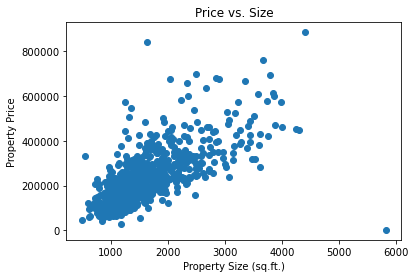

In [13]:
# Explore price variable
# Plot price vs sq__ft

plt.scatter(x=df_nonzero['sq__ft'], y=df_nonzero['price'])
plt.ylabel('Property Price')
plt.xlabel('Property Size (sq.ft.)')
plt.title('Price vs. Size');

In [14]:
# After plotting property price and its size, outlier reveals.
# Recheck outlier by sorting data 
df_nonzero.sort_values(by='price').head()

,street,city,beds,baths,sq__ft,type,price
866,14151 INDIO DR,SLOUGHHOUSE,3,4,5822,Residential,2000
603,8208 WOODYARD WAY,CITRUS HEIGHTS,3,2,1166,Residential,30000
335,5840 WALERGA RD,SACRAMENTO,2,1,840,Condo,40000
336,923 FULTON AVE,SACRAMENTO,1,1,484,Condo,48000
605,15 LOORZ CT,SACRAMENTO,2,1,838,Residential,55422


In [15]:
# Drop data that price = 2000
df_nonzero = df_nonzero[df_nonzero['price'] > 2000].copy()

In [16]:
# Re-check data shape
df_nonzero.shape

(812, 7)

In [17]:
# Check data types
# sale_date is now in format of object.
df_nonzero.dtypes

street    object
city      object
beds       int64
baths      int64
sq__ft     int64
type      object
price      int64
dtype: object

In [18]:
# Check categorical variables.
# Street name.
df_nonzero['street'].unique()

array(['3526 HIGH ST', '51 OMAHA CT', '2796 BRANCH ST',
       '2805 JANETTE WAY', '6001 MCMAHON DR', '5828 PEPPERMILL CT',
       '6048 OGDEN NASH WAY', '2561 19TH AVE',
       '11150 TRINITY RIVER DR Unit 114', '7325 10TH ST',
       '645 MORRISON AVE', '4085 FAWN CIR', '2930 LA ROSA RD',
       '2113 KIRK WAY', '4533 LOCH HAVEN WAY', '7340 HAMDEN PL',
       '6715 6TH ST', '6236 LONGFORD DR Unit 1', '250 PERALTA AVE',
       '113 LEEWILL AVE', '6118 STONEHAND AVE', '4882 BANDALIN WAY',
       '7511 OAKVALE CT', '9 PASTURE CT', '3729 BAINBRIDGE DR',
       '3828 BLACKFOOT WAY', '4108 NORTON WAY', '1469 JANRICK AVE',
       '9861 CULP WAY', '7825 CREEK VALLEY CIR',
       '5201 LAGUNA OAKS DR Unit 140', '6768 MEDORA DR',
       '3100 EXPLORER DR', '7944 DOMINION WAY',
       '5201 LAGUNA OAKS DR Unit 162', '3920 SHINING STAR DR',
       '5031 CORVAIR ST', '7661 NIXOS WAY', '7044 CARTHY WAY',
       '2442 LARKSPUR LN', '4800 WESTLAKE PKWY Unit 2109',
       '2178 63RD AVE', '8718 ELK W

In [19]:
# Check city name.
df_nonzero['city'].unique()

array(['SACRAMENTO', 'RANCHO CORDOVA', 'RIO LINDA', 'CITRUS HEIGHTS',
       'NORTH HIGHLANDS', 'ANTELOPE', 'ELK GROVE', 'ELVERTA', 'GALT',
       'CARMICHAEL', 'ORANGEVALE', 'FOLSOM', 'MATHER', 'POLLOCK PINES',
       'GOLD RIVER', 'RANCHO MURIETA', 'WILTON', 'GREENWOOD', 'FAIR OAKS',
       'PLACERVILLE', 'MEADOW VISTA', 'ROSEVILLE', 'LINCOLN',
       'CAMERON PARK', 'ROCKLIN', 'LOOMIS', 'AUBURN', 'EL DORADO HILLS',
       'EL DORADO', 'PENRYN', 'GRANITE BAY', 'DIAMOND SPRINGS', 'COOL',
       'WALNUT GROVE', 'WEST SACRAMENTO'], dtype=object)

In [20]:
# df_nonzero['city'].value_counts()

In [21]:
# Check property type.
df_nonzero['type'].unique()

array(['Residential', 'Condo', 'Multi-Family'], dtype=object)

In [22]:
# Final check data look
df_nonzero

,street,city,beds,baths,sq__ft,type,price
0,3526 HIGH ST,SACRAMENTO,2,1,836,Residential,59222
1,51 OMAHA CT,SACRAMENTO,3,1,1167,Residential,68212
2,2796 BRANCH ST,SACRAMENTO,2,1,796,Residential,68880
3,2805 JANETTE WAY,SACRAMENTO,2,1,852,Residential,69307
4,6001 MCMAHON DR,SACRAMENTO,2,1,797,Residential,81900
...,...,...,...,...,...,...,...
980,9169 GARLINGTON CT,SACRAMENTO,4,3,2280,Residential,232425
981,6932 RUSKUT WAY,SACRAMENTO,3,2,1477,Residential,234000
982,7933 DAFFODIL WAY,CITRUS HEIGHTS,3,2,1216,Residential,235000
983,8304 RED FOX WAY,ELK GROVE,4,2,1685,Residential,235301


When you've finished cleaning or have made a good deal of progress cleaning, it's always a good idea to save your work. Use the pandas `to_csv` method to export your cleaned dataset.

```python
# example -- your dataframe name may be different
dataframe.to_csv('./datasets/sacramento_cleaned_dataframe.csv', index=False)

```

In [23]:
df_nonzero.to_csv('./datasets/sacramento_dropzero.csv', index=False)

### 3. Our goal will be to predict price. List variables that you think qualify as predictors of price in an SLR model.

For each of the variables you believe should be considered, generate a plot showing the relationship between the independent and dependent variables.

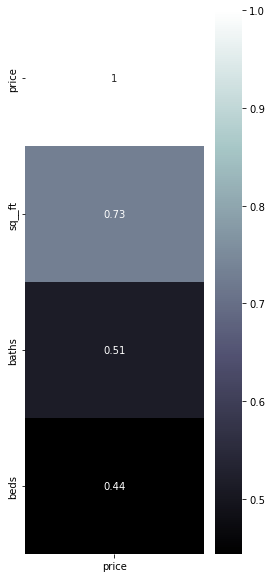

In [24]:
corr = df_nonzero.corr()[['price']].sort_values(by='price', ascending=False).head(10)

plt.figure(figsize=(4, 10))
sns.heatmap(corr, annot=True, cmap='bone');

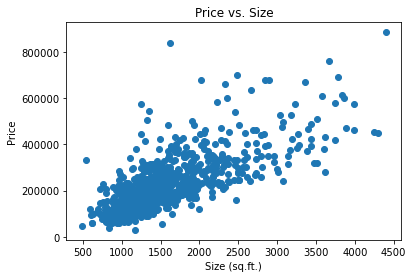

In [25]:
# Plot price vs. size
plt.scatter(df_nonzero['sq__ft'], df_nonzero['price'])
plt.xlabel('Size (sq.ft.)')
plt.ylabel('Price')
plt.title('Price vs. Size');

### 4. Which variable would be the best predictor of Y in an SLR model? Why?

In [26]:
#sq__ft variable because the feature's correlation is highest among all features.

### 5. Write a function that will take in two lists, `x` and `y`, and return the intercept and slope coefficients that minimize SSE. 

`y` is the target variable, and `x` is the predictor variable.

**Don't use scikit-learn for this**. Instead, use numpy and scipy.

The slope and intercept of simple linear regression can be calculated by using certain summary statistics. In particular, we'll need to know:

- $\bar{x}$, the mean of `x`
- $\bar{y}$, the mean of `y`
- $s_{x}$, the standard deviation of `x`
- $s_{y}$, the standard deviation of `y`
- $r_{xy}$, the correlation of `x` and `y`

Given these summary statistics, the **coefficient on `X`** (or the slope) can be given by $\beta_{1} = r_{xy} * \frac{s_{y}}{s_{x}}$. The **intercept of the model** can be given by $\beta_{0} = \bar{y} - \beta_{1}\bar{x}$.

Your function should take in `x` and `y`, then use the above summary statistics to calculate the slope and intercept.

- **Test your function on price and the variable you determined was the best predictor in Problem 4.**
- **Report the slope and intercept.**

In [27]:
def simple_linear(x, y):
    corr = pd.DataFrame({'x': x, 'y': y}).corr()['x'][1]
    b1 = corr * statistics.stdev(y) / statistics.stdev(x)
    b0 = np.mean(y) - b1 * np.mean(x)
    print(f'Y interception of model: {b0}, Slope of model: {b1}')
    return (b0, b1)

In [28]:
simple_linear(df_nonzero['sq__ft'], df_nonzero['price'])

Y interception of model: 15943.749961489084, Slope of model: 134.7512075418883


(15943.749961489084, 134.7512075418883)

In [29]:
# Test with sklearn regresion 
X = df_nonzero[['sq__ft']]
y = df_nonzero['price']

lr = LinearRegression()
lr.fit(X, y)
print(lr.intercept_)
print(lr.coef_)
print(lr.score(X, y))

15943.749961489317
[134.75120754]
0.5312391921867458


### 6. Interpret the intercept and the slope.

In [30]:
# Y interception: If there is no effect of x, which is sq__ft = 0, the expected house price would be about 15,943 USD.
# It should be avoided from interpretation because it dose not make sense to have house that is 0 sq.ft.  

# Slope: If property size increases 1 sq.ft., property price will increases about 134.75 USD.

### 7. Give an example of how this model could be used for prediction and how it could be used for inference. 

**Be sure to make it clear which example is associated with prediction and which is associated with inference.**

In [31]:
# Inference example:
## To understand relationship of property size and its price.

# Prediction example:
## To predict property price from given property size.

### 8: Using the model you came up with in Problem 5, calculate and plot the residuals.

Y interception of model: 15943.749961489084, Slope of model: 134.7512075418883


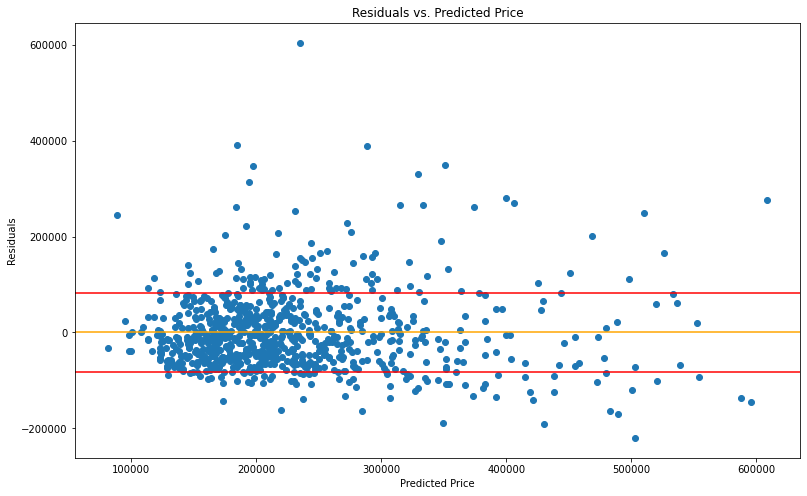

In [32]:
# Calculate b0 and b1.
b0, b1 = simple_linear(df_nonzero['sq__ft'], df_nonzero['price'])

# Predict price from sq__ft using math model.
y_preds = b0 + b1 * df_nonzero['sq__ft']

# Calculate residuals.
res = df_nonzero['price'] - y_preds

# Plot residuals
plt.figure(figsize=(13, 8))
plt.scatter(y_preds, res)
plt.axhline(0, color='orange')
plt.axhline(np.std(res), color='red')
plt.axhline(-np.std(res), color='red')
plt.title('Residuals vs. Predicted Price')
plt.xlabel('Predicted Price')
plt.ylabel('Residuals');

In [33]:
res.isnull().sum()

0

---

## Dummy Variables

It is important to be cautious with categorical variables, which represent distinct groups or categories, when building a regression. If put in a regression "as-is," categorical variables represented as integers will be treated like *continuous* variables.

That is to say, instead of group "3" having a different effect on the estimation than group "1" it will estimate literally 3 times more than group 1. 

For example, if occupation category "1" represents "analyst" and occupation category "3" represents "barista", and our target variable is salary, if we leave this as a column of integers then barista will always have `beta*3` the effect of analyst.

This will almost certainly force the beta coefficient to be something strange and incorrect. Instead, we can re-represent the categories as multiple "dummy coded" columns.



#### A Word of Caution When Creating Dummies

Let's touch on precautions we should take when dummy coding.

**If you convert a qualitative variable to dummy variables, you want to turn a variable with N categories into N-1 variables.**

> **Scenario 1:** Suppose we're working with the variable "sex" or "gender" with values "M" and "F". 

You should include in your model only one variable for "sex = F" which takes on 1 if sex is female and 0 if sex is not female! Rather than saying "a one unit change in X," the coefficient associated with "sex = F" is interpreted as the average change in Y when sex = F relative to when sex = M.

| Female | Male | 
|-------|------|
| 0 | 1 | 
| 1 | 0 |
| 0 | 1 |
| 1 | 0 |
| 1 | 0 |
_As we can see a 1 in the female column indicates a 0 in the male column. And so, we have two columns stating the same information in different ways._

> Scenario 2: Suppose we're modeling revenue at a bar for each of the days of the week. We have a column with strings identifying which day of the week this observation occurred in.

We might include six of the days as their own variables: "Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday". **But not all 7 days.**  

|Monday | Tuesday | Wednesday | Thursday | Friday | Saturday | 
|-------|---------|-----------|----------|--------|----------|
| 1     | 0       |0          |      0   |0       | 0        | 
| 0     | 1       |0          |      0   |0       | 0        | 
| 0     | 0       |1          |      0   |0       | 0        | 
| 0     | 0       |0          |      1   |0       | 0        | 
| 0     | 0       |0          |      0   |1       | 0        | 
| 0     | 0       |0          |      0   |0       | 1        | 
| 0     | 0       |0          |      0   |0       | 0        | 

_As humans we can infer from the last row that if its is not Monday, Tuesday, Wednesday, Thursday, Friday or Saturday, it must be Sunday. Models work the same way._

The coefficient for Monday is then interpreted as the average change in revenue when "day = Monday" relative to "day = Sunday." The coefficient for Tuesday is interpreted as the average change in revenue when "day = Tuesday" relative to "day = Sunday" and so on.

The category you leave out, which the other columns are *relative to*, is often referred to as the **reference category**.

### 9. Use the `pd.get_dummies` function to convert the `type` column into dummy-coded variables.

In [36]:
def street_to_type(street):
    """Function to find street type from given street name"""
    street_split = street.split()
    if street_split[-2] == 'Unit':
        return street_split[-3]
    elif street_split[-1].isnumeric():
        return street_split[-2]
    else:
        return street_split[-1]

In [37]:
# Apply street_to_type function to dataset.
df_nonzero['street_last'] = df_nonzero['street'].apply(street_to_type)

In [38]:
# Get dummy for categorical variables
df_nonzero = df_nonzero.merge(pd.get_dummies(df_nonzero[['street_last', 'city', 'type']]), left_index=True, right_index=True).copy()

### 10. Check the dummy columns you've created. Do they all make sense?

Use `.head()` on the new dataframe you've created. Depending on how you cleaned the data earlier in this notebook, there may be a dummy column that needs to be removed. Check that all the columns you've created make sense, and if any of the columns seem to be errors, drop them. If there don't appear to be any errors, then move on to the next step!

In [39]:
# Check the result
df_nonzero.head()

,street,city,beds,baths,sq__ft,type,price,street_last,street_last_AVE,street_last_BLVD,...,city_RIO LINDA,city_ROCKLIN,city_ROSEVILLE,city_SACRAMENTO,city_WALNUT GROVE,city_WEST SACRAMENTO,city_WILTON,type_Condo,type_Multi-Family,type_Residential
0,3526 HIGH ST,SACRAMENTO,2,1,836,Residential,59222,ST,0,0,...,0,0,0,1,0,0,0,0,0,1
1,51 OMAHA CT,SACRAMENTO,3,1,1167,Residential,68212,CT,0,0,...,0,0,0,1,0,0,0,0,0,1
2,2796 BRANCH ST,SACRAMENTO,2,1,796,Residential,68880,ST,0,0,...,0,0,0,1,0,0,0,0,0,1
3,2805 JANETTE WAY,SACRAMENTO,2,1,852,Residential,69307,WAY,0,0,...,0,0,0,1,0,0,0,0,0,1
4,6001 MCMAHON DR,SACRAMENTO,2,1,797,Residential,81900,DR,0,0,...,0,0,0,1,0,0,0,0,0,1


### 11. Build what you think may be the best MLR model predicting `price`. 

Choose at least three variables, and build a model that uses them to predict price. At least one of the variables you choose should be a dummy-coded variable. (This can be one we created before or a new one.) 

You may need to load in the scikit-learn API:

```python
from sklearn.linear_model import LinearRegression

model = LinearRegression()
```

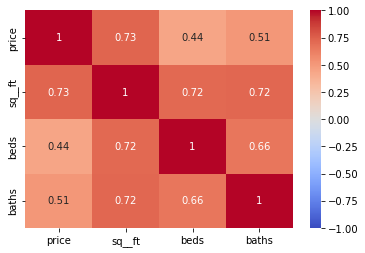

In [40]:
# Plot correlation between X
sns.heatmap(df_nonzero[['price', 'sq__ft', 'beds', 'baths']].corr(),
            vmax=1,
            vmin=-1,
            annot=True,
            cmap='coolwarm');

# sq__ft has high correlation with beds and baths, so we can use only 1 feature to avoid multicollinearity.

In [41]:
df_nonzero.groupby(['street_last'])['price'].agg(['count','mean']).sort_values(by='mean', ascending=False)

,count,mean
street_last,,
HIGHWAY,1,485000.000000
CONEJO,1,425000.000000
HL,1,350000.000000
TRL,1,300000.000000
LN,32,266927.937500
CT,102,258386.470588
MARTINA,1,255000.000000
PL,7,250671.428571
CIR,67,246363.044776


In [42]:
df_nonzero.groupby(['city'])['price'].agg(['count','mean']).sort_values(by='mean', ascending=False)

,count,mean
city,,
GRANITE BAY,3,678733.333333
WILTON,4,631885.500000
LOOMIS,2,567000.000000
PENRYN,1,506688.000000
FOLSOM,15,415288.200000
PLACERVILLE,5,404709.600000
CAMERON PARK,1,399000.000000
RANCHO MURIETA,2,397750.000000
GREENWOOD,1,395000.000000


In [43]:
X = df_nonzero[['sq__ft','beds', 'baths', 'city_SACRAMENTO', 'street_last_CT']]
y = df_nonzero['price']

model = LinearRegression()
model.fit(X, y)

# Train score
print(f'Train R-squared Scores: {model.score(X, y)}')

y_preds = model.predict(X)
residual = y - y_preds

Train R-squared Scores: 0.5632715058249353


### 12. Plot the true price vs the predicted price to evaluate your MLR visually.

You can use matplotlib or seaborn.

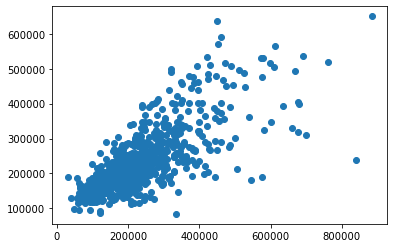

In [44]:
plt.scatter(y, y_preds);

### 13. List the five assumptions for an MLR model. 

Indicate which ones are the same as the assumptions for an SLR model. 

#### List 5 assumtions
1. L - Linear relationship for X, y
2. I - Independent of each y
3. N - Normal distribution of residual
4. E - Equal varaince for every predicted y
5. M - No Multicollineariry of X

#### Assumption 1-4 are the same as SLR

### 14. Pick at least two assumptions and explain whether or not you believe them to be met for your model, and explain why.

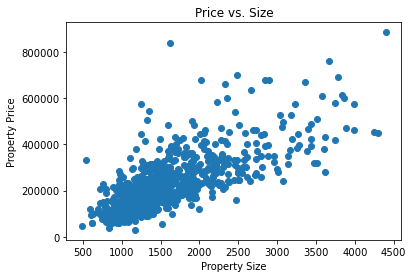

In [45]:
# L - Linear relationship for X, y

plt.scatter(df_nonzero['sq__ft'], df_nonzero['price'])
plt.title('Price vs. Size')
plt.xlabel('Property Size')
plt.ylabel('Property Price');


## one of x variable is likely to be linear realationship with y.

In [46]:
# I - Independence of observations
## Since data is not time series, there is no concern.

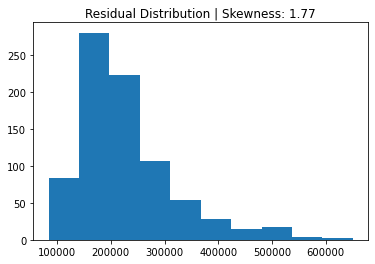

In [47]:
# N - Normality in residual distribution

plt.hist(y_preds)
plt.title(f'Residual Distribution | Skewness: {pd.Series(residual).skew().round(2)}');

## From the result, residuals distribution is not normal and has a right skew.

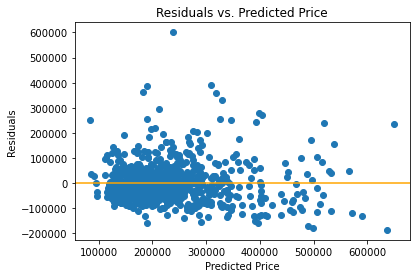

In [48]:
# E - Equility of residual

plt.scatter(y_preds, residual)
plt.axhline(0, color='orange')
plt.title('Residuals vs. Predicted Price')
plt.xlabel('Predicted Price')
plt.ylabel('Residuals');

## Residuals seem to be homoscedasticity, 
## which mean reidual are distributed among all of predicted prices.

In [49]:
# M - No multicollinearity of predictors
X[['sq__ft', 'beds', 'baths']].corr()

## There is highly correlated of baths, beds, and sq__ft
## that could lead to multicollinearity of these variables.

,sq__ft,beds,baths
sq__ft,1.000000,0.716569,0.722744
beds,0.716569,1.000000,0.658620
baths,0.722744,0.658620,1.000000


### 15. [Bonus] Generate a table showing the point estimates, standard errors, t-scores, p-values, and 95% confidence intervals for the model you built. 

**Write a few sentences interpreting some of the output.**

> **Hint:** scikit-learn does not have this functionality built in, but statsmodels does in the `summary` method.  To fit the statsmodels model use something like the following.  There is one big caveat here, however!  `statsmodels.OLS` does _not_ add an intercept to your model, so you will need to do this explicitly by adding a column filled with the number 1 to your X matrix

```python
import statsmodels.api as sm

# The Default here is Linear Regression (ordinary least squares regression OLS)
model = sm.OLS(y,X).fit()
```

In [50]:
import statsmodels.api as sm

In [51]:
X_const = X.copy()
X_const['const'] = 1
model_sm = sm.OLS(y, X_const).fit()
model_sm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.563
Model:                            OLS   Adj. R-squared:                  0.561
Method:                 Least Squares   F-statistic:                     207.9
Date:                Fri, 16 Sep 2022   Prob (F-statistic):          2.62e-142
Time:                        08:09:25   Log-Likelihood:                -10310.
No. Observations:                 812   AIC:                         2.063e+04
Df Residuals:                     806   BIC:                         2.066e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
sq__ft            148.5357      7.086     20.962      0.000     134.627     162.445
beds            -2.162e+04   4929.173     -4.386      0.000   -3.13e+04   -1.19e+04
baths             622.6009   6375.578      0.098      0.922   -1.19e+04    1.31e+04
city_SACRAMENTO -3.417e+04   5760.862     -5.932      0.000   -4.55e+04   -2.29e+04
street_last_CT    645.8811   8513.974      0.076      0.940   -1.61e+04    1.74e+04
const            8.078e+04   1.22e+04      6.639      0.000    5.69e+04    1.05e+05
==============================================================================
Omnibus:                      336.648   Durbin-Watson:                   1.219
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2078.106
Skew:                           1.769   Prob(JB):                         0.00
Kurtosis:                       9.993   Cond. No.                     7.86e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 7.86e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### 16. Regression Metrics

Implement a function called `r2_adj()` that will calculate $R^2_{adj}$ for a model. 

In [52]:
def r2_adj(model, X, y):
    return 1 - (1-model.score(X, y)) * (len(y) - 1 ) / (len(y) - X.shape[1] - 1)

In [53]:
r2_adj(model, X, y)

0.5605622719901024

### 17. Metrics, metrics, everywhere...

Calculate and interpret at least three regression metrics. How well does your model perform?

In [54]:
print('R^2:', metrics.r2_score(y, y_preds))
print('MAE', metrics.mean_absolute_error(y, y_preds))
print('RMSE:', metrics.mean_squared_error(y, y_preds, squared=False))

## 56% of variability in property price is explained by X of the model
## MAE and RMSE can explain how off model prediction is but RMSE is more sensitive than MAE
## which means predicted y can be off up to 79,058 USD.

R^2: 0.5632715058249353
MAE 56165.56085455379
RMSE: 79058.81033701167


### 18. Model Iteration

Adjust your model by adding or removing a variable. Then calculate the same regression metrics as you used in question 17. Has your model performance increased or decreased?

In [55]:
# create function to return model metrics

def reg_metrics(X, y):
    """Print model metrics and return regression model
    from given X, y"""
    # Split data.
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)
    
    # Train model
    model = LinearRegression()
    model.fit(X_train, y_train)
    
    # Create metrics - train
    y_train_preds = model.predict(X_train)
    train_mae = metrics.mean_absolute_error(y_train, y_train_preds)
    train_rmse = metrics.mean_squared_error(y_train, y_train_preds, squared=False)
    train_r2 = metrics.r2_score(y_train, y_train_preds)
    train_adj_r2 = r2_adj(model, X_train, y_train)
    
    # Create metrics - test
    y_test_preds = model.predict(X_test)
    test_mae = metrics.mean_absolute_error(y_test, y_test_preds)
    test_rmse = metrics.mean_squared_error(y_test, y_test_preds, squared=False)
    test_r2 = metrics.r2_score(y_test, y_test_preds)
    test_adj_r2 = r2_adj(model, X_test, y_test)
    
    print(f"""-----------Train Data-----------
MAE: {train_mae}
RMSE: {train_rmse}
R2: {train_r2}
Adj_R2: {train_adj_r2}
Cross Validation: {cross_val_score(model, X_train, y_train)}
Cross Validation Mean: {cross_val_score(model, X_train, y_train).mean()}
--------------------------------""")
    print(f"""-----------Test Data-----------
MAE: {test_mae}
RMSE: {test_rmse}
R2: {test_r2}
Adj_R2: {test_adj_r2}
--------------------------------""")
    return model

In [56]:
# Baseline model
# X = df_nonzero[['sq__ft','beds', 'baths', 'city_SACRAMENTO', 'street_last_CT']]
# y = df_nonzero['price']

reg_metrics(X, y)

-----------Train Data-----------
MAE: 56191.14460063044
RMSE: 76840.23308934947
R2: 0.5858772069824589
Adj_R2: 0.5824433529773383
Cross Validation: [0.5501967  0.58098971 0.45283198 0.57293174 0.66207119]
Cross Validation Mean: 0.5638042632867508
--------------------------------
-----------Test Data-----------
MAE: 55428.499299217816
RMSE: 86041.7373100596
R2: 0.48796968524898354
Adj_R2: 0.4749739919811913
--------------------------------


LinearRegression()

In [58]:
# Model 1 : Basline model
X = df_nonzero[['sq__ft','beds', 'city_SACRAMENTO', 'street_last_CT']]
y = df_nonzero['price']

reg_metrics(X, y)

-----------Train Data-----------
MAE: 56229.900499413336
RMSE: 76877.18188672974
R2: 0.5854788474930104
Adj_R2: 0.5827336742975999
Cross Validation: [0.55265639 0.58063367 0.45484656 0.57238719 0.6616255 ]
Cross Validation Mean: 0.5644298615479053
--------------------------------
-----------Test Data-----------
MAE: 55438.6999614994
RMSE: 85771.61175362684
R2: 0.4911796473902855
Adj_R2: 0.4809004483476651
--------------------------------


LinearRegression()

In [60]:
# Model 2 : Dump all city dummies
X = df_nonzero[['sq__ft','beds', 'city']]
X = pd.get_dummies(X, drop_first=True)
y = df_nonzero['price']

reg_metrics(X, y)

## Use all city for dummies vairable could improve predictive power of the model.

-----------Train Data-----------
MAE: 49729.39894367622
RMSE: 67855.1449603573
R2: 0.6770633375896256
Adj_R2: 0.6567386525428187
Cross Validation: [0.54105938 0.60782142 0.54126719 0.63013518 0.71638791]
Cross Validation Mean: 0.6073342170890609
--------------------------------
-----------Test Data-----------
MAE: 50084.1962755706
RMSE: 78105.94642314847
R2: 0.5780650207016089
Adj_R2: 0.4865610492875
--------------------------------


LinearRegression()

In [66]:
# Model 3 : Dump all city, type dummies
X = df_nonzero[['sq__ft','beds', 'city', 'type']]
X = pd.get_dummies(X, drop_first=True)
y = df_nonzero['price']

reg_metrics(X, y)

## Dump all type to model could make a litter improve of prdiction.
### While based type is condo

-----------Train Data-----------
MAE: 48835.95947669064
RMSE: 66984.58608283068
R2: 0.6852965214384279
Adj_R2: 0.6643162895343231
Cross Validation: [0.55792773 0.6304996  0.51642053 0.62925072 0.72804007]
Cross Validation Mean: 0.6124277286685007
--------------------------------
-----------Test Data-----------
MAE: 49904.92845531225
RMSE: 77617.62513853566
R2: 0.5833244345151034
Adj_R2: 0.4867776571466518
--------------------------------


LinearRegression()

In [66]:
# Model 3 : Dump all city, street dummies
X = df_nonzero[['sq__ft','beds', 'city', 'type']]
X = pd.get_dummies(X, drop_first=True)
y = df_nonzero['price']

reg_metrics(X, y)

## Dump all type to model could make a litter improve of prdiction.
### While based type is condo

-----------Train Data-----------
MAE: 48835.95947669064
RMSE: 66984.58608283068
R2: 0.6852965214384279
Adj_R2: 0.6643162895343231
Cross Validation: [0.55792773 0.6304996  0.51642053 0.62925072 0.72804007]
Cross Validation Mean: 0.6124277286685007
--------------------------------
-----------Test Data-----------
MAE: 49904.92845531225
RMSE: 77617.62513853566
R2: 0.5833244345151034
Adj_R2: 0.4867776571466518
--------------------------------


LinearRegression()

### 19. Bias vs. Variance

_(To be completed after the bias-variance tradeoff lecture.)_ At this point, do you think your model is high bias, high variance or in the sweet spot?

In [ ]:
# The model is high bias, which could only explain variabiliby in y only for 56%.
# Since R^2 from test and train data are not highly different, a variance of the model are low.